In [1]:
import os
import numpy as np

from handcrafted.app.dataset.utils.dataset_creator import DatasetCreator
from handcrafted.app.model.model_statistics import ModelStatistics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from handcrafted.app.dataset.dataset_loader import DatasetLoader
from handcrafted.app.dataset.utils.frames_splitter import FramesSplitter

In [2]:
loader = DatasetLoader(directory="./data/frames_no_bg/")

345it [00:01, 291.34it/s]


In [3]:
splitter = FramesSplitter(loader.signers, val_split=0.3, test_split=0.3, frames_split=0.1, seed=42)

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter.split()

100%|██████████| 4/4 [00:00<00:00, 154.37it/s]


In [5]:
# Get the total of different labels
num_classes = loader.num_signers
print(num_classes)

4


In [6]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

In [9]:
BATCH_SIZE = 32
dataset_creator = DatasetCreator()
train_dataset = dataset_creator.create_dataset(X_train, y_train_onehot, num_aug=3, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = dataset_creator.create_dataset(X_val, y_val_onehot, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = dataset_creator.create_dataset(X_test, y_test_onehot, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def build_vggface():
    model = keras.Sequential(
        [
            layers.Input(shape=(224, 224, 3), name='input'),
            layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv1_1-relu1_1'),
            layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv1_2-relu1_2'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool1'),
            layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv2_1-relu2_1'),
            layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv2_2-relu2_2'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool2'),
            layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv3_1-relu3_1'),
            layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv3_2-relu3_2'),
            layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv3_3-relu3_3'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool3'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv4_1-relu4_1'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv4_2-relu4_2'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv4_3-relu4_3'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool4'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv5_1-relu5_1'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv5_2-relu5_2'),
            layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv5_3-relu5_3'),
            layers.MaxPooling2D(pool_size=2, strides=2, name='pool5'),
            layers.Conv2D(filters=4096, kernel_size=7, activation='relu', name='fc6-relu6'),
            layers.Dropout(0.5, name='do6'),
            layers.Conv2D(filters=4096, kernel_size=1, activation='relu', name='fc7-relu7'),
            layers.Dropout(0.5, name='do7'),
            layers.Conv2D(filters=num_classes, kernel_size=1, activation='softmax', name='fc8-prob'),
            layers.Flatten(name='flatten'),
        ]
    )

    return model

In [11]:
def build_small_cnn(num_classes):
    model = keras.Sequential([
        layers.Input(shape=(224, 224, 3), name='input'),
        # First convolutional block
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool1'),
        # Second convolutional block
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool2'),
        # Third convolutional block
        layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool3'),
        # Flatten and dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ])
    return model

In [12]:
model = build_small_cnn(num_classes)
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# model.load_weights('vgg_face_weights.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
checkpoint_filepath = "model.ckpt"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True
)


In [14]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
model.fit(
    train_dataset,
    batch_size=128,
    epochs=2,
    # steps_per_epoch=(len(X_train) * NUM_AUG) // batch_size,
    validation_data=val_dataset,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1,
)

Epoch 1/2
    140/Unknown 104s 686ms/step - accuracy: 0.6586 - loss: 10.2918

C:\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 721ms/step - accuracy: 0.6590 - loss: 10.2407 - val_accuracy: 0.7162 - val_loss: 1.0310
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 99s 664ms/step - accuracy: 0.7360 - loss: 0.8356 - val_accuracy: 0.7162 - val_loss: 0.9891


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.7191 - loss: 0.9776


In [17]:
y_pred = model.predict(test_dataset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step


In [18]:
y_pred_indices = np.argmax(y_pred, axis=1)
y_pred_original = label_encoder.inverse_transform(y_pred_indices)

In [19]:
print(len(y_test))
print(len(y_pred_original))

965
965


Accuracy: 72.02%
Confusion matrix saved at signer/plots\svc_signer_test_965.png


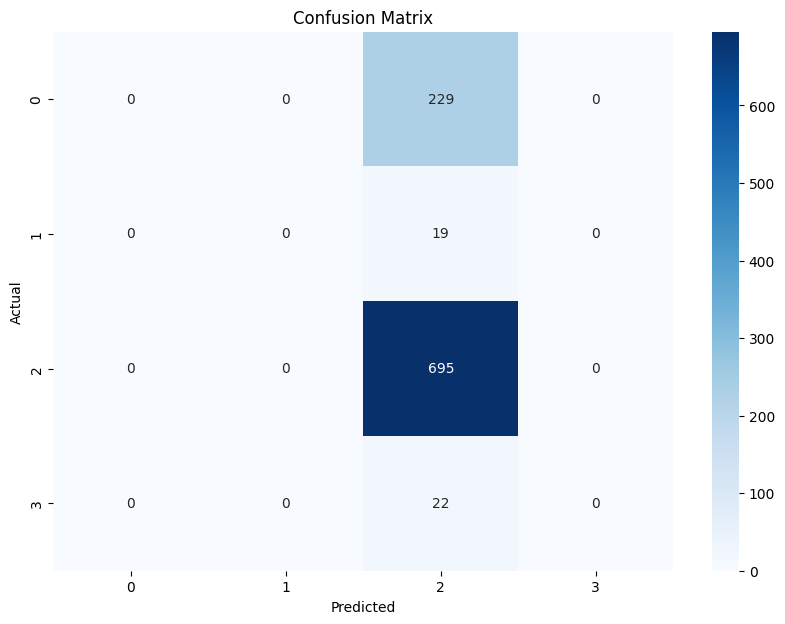

In [20]:
stats = ModelStatistics(save_name=f"svc_signer_test_{len(y_test)}", save_dir="signer/plots")
stats.print_accuracy(y_test, y_pred_original)
stats.plot_confusion_matrix(y_test, y_pred_original, save=True, plot=True)